In [11]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

There are two options for calibrating two cameras.
1. Calibrate each camera's intrinsics separately, and then use `cv2.stereoCalibrate` with fixed intrinsics.
2. Do intrinsic and extrinsic calibration in one shot using `cv2.stereoCalibrate`.

In [12]:
# Checkerboard config
CHECKERBOARD = (9, 6)
SQUARE_SIZE = 0.023 # 2.3cm

# Prepare 3D object points
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = (
    np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1,2) * SQUARE_SIZE
)

# Arrays to store points
objpoints = [] # 3D real-world points (same for both cams)
imgpoints_l = []    # 2D points in left image
imgpoints_r = []    # 2D points in right image

In [13]:
# Load the stereo image pairs
FOLDER = "checkerboard"
left_images = sorted(glob.glob(f"{FOLDER}/left_*.jpg"))
right_images = sorted(glob.glob(f"{FOLDER}/right_*.jpg"))

assert len(left_images) == len(right_images), "Mismatched pair count"

In [14]:
# Detect corners in each pair
for left_img_path, right_img_path in zip(left_images, right_images):
    img_l = cv2.imread(left_img_path)
    img_r = cv2.imread(right_img_path)

    gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
    gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

    # Try to find corners
    ret_l, corners_l = cv2.findChessboardCorners(gray_l, CHECKERBOARD, None)
    ret_r, corners_r = cv2.findChessboardCorners(gray_r, CHECKERBOARD, None)

    # Only continue if both cameras detected the board
    if ret_l and ret_r:
        objpoints.append(objp)

        # Corner refinement
        criteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            30,
            0.001,
        )
        corners_l = cv2.cornerSubPix(gray_l, corners_l, (11, 11), (-1, -1), criteria)
        corners_r = cv2.cornerSubPix(gray_r, corners_r, (11, 11), (-1, -1), criteria)

        imgpoints_l.append(corners_l)
        imgpoints_r.append(corners_r)

print(f"Using {len(objpoints)} stereo pairs.")

Using 35 stereo pairs.


In [15]:
# Perform stereo calibration
img_shape = gray_l.shape[::-1]  # (width, height)

# Estimate intrinsics and extrinsics together
flags = cv2.CALIB_FIX_INTRINSIC
cameraMatrix1 = None
distCoeffs1 = None
cameraMatrix2 = None
distCoeffs2 = None

# Run calibration
ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = \
cv2.stereoCalibrate(
    objectPoints=objpoints,
    imagePoints1=imgpoints_l,
    imagePoints2=imgpoints_r,
    cameraMatrix1=cameraMatrix1,
    distCoeffs1=distCoeffs1,
    cameraMatrix2=cameraMatrix2,
    distCoeffs2=distCoeffs2,
    imageSize=img_shape,
    criteria=(
        cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,
        100,
        1e-5,
    ),
    flags=0 # allow intrinsics and extrinsics to be optimized
)

print("Calibration complete")
print("Reprojection error:", ret)
print("Left camera matrix:\n", cameraMatrix1)
print("Right camera matrix:\n", cameraMatrix2)
print("Rotation between cameras:\n", R)
print("Translation between cameras:\n", T)

Calibration complete
Reprojection error: 0.7075534722746103
Left camera matrix:
 [[1.02764820e+03 0.00000000e+00 6.34125083e+02]
 [0.00000000e+00 1.03034091e+03 3.52998239e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Right camera matrix:
 [[1.01928746e+03 0.00000000e+00 6.50276441e+02]
 [0.00000000e+00 1.02211992e+03 3.57413103e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation between cameras:
 [[ 0.99979594 -0.0140368   0.01452721]
 [ 0.01384361  0.99981552  0.01331484]
 [-0.01471143 -0.01311101  0.99980582]]
Translation between cameras:
 [[-0.18655662]
 [-0.00210376]
 [-0.00092256]]


In [16]:
# save the fitted parameters
np.savez(
    "stereo_calib.npz",
    cameraMatrix1=cameraMatrix1,
    distCoeffs1=distCoeffs1,
    cameraMatrix2=cameraMatrix2,
    distCoeffs2=distCoeffs2,
    R=R,
    T=T,
    E=E,
    F=F,
)

Visualize cameras in 3D space

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

data = np.load("stereo_calib.npz")

R = data["R"]
T = data["T"].reshape(3, 1)

# Compute camera centers and rotations in the camera0/world coords
C0 = np.zeros((3, 1))
R0 = np.eye(3)

# Right camera center and rotation. Convert from OpenCV stereoCalibrate outputs
C1 = -R.T @ T
R1 = R.T

# OpenCV coords (x right, y down, z forward)
# to plotting coords (x right, y up, z forward)
def cv_to_plot_coords(v):
    return np.array([v[0], -v[1], v[2]])

def plot_camera(ax, R, t, color='blue', scale=0.1, label=""):
    """
    R, t define camera pose in the world:
        X_world = R * X_cam + t
    """
    # Convert center and axes to plotting coords
    C = cv_to_plot_coords(t)
    x_axis = cv_to_plot_coords(R @ np.array([1,0,0]))
    y_axis = cv_to_plot_coords(R @ np.array([0,1,0]))
    z_axis = cv_to_plot_coords(R @ np.array([0,0,1]))

    # Draw axes (quiver)
    ax.quiver(*C, *(x_axis - C), length=scale, color='red')
    ax.quiver(*C, *(y_axis - C), length=scale, color='green')
    ax.quiver(*C, *(z_axis - C), length=scale, color='blue')

    # Draw frustum pyramid in camera coords
    depth = scale * 2
    w = h = scale

    pts = np.array([
        [0, 0, 0],  # cam origin
        [-w, -h, depth],
        [w, -h, depth],
        [w, h, depth],
        [-w, h, depth]
    ])

    # Transform and convert points
    pts_w = np.array([cv_to_plot_coords(R @ p + t) for p in pts])

    # Draw pyramid edges
    for i in range(1, 5):
        ax.plot([pts_w[0,0], pts_w[i,0]],
                [pts_w[0,1], pts_w[i,1]],
                [pts_w[0,2], pts_w[i,2]], color=color, linewidth=1.5)
    for i in range(1, 5):
        j = i+1 if i < 4 else 1
        ax.plot([pts_w[i,0], pts_w[j,0]],
                [pts_w[i,1], pts_w[j,1]],
                [pts_w[i,2], pts_w[j,2]], color=color, linewidth=1.0)
    
    ax.text(*C, label, color=color)

def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]

    max_range = max(x_range, y_range, z_range)

    x_mid = 0.5 * sum(x_limits)
    y_mid = 0.5 * sum(y_limits)
    z_mid = 0.5 * sum(z_limits)

    ax.set_xlim3d([x_mid - max_range/2, x_mid + max_range/2])
    ax.set_ylim3d([y_mid - max_range/2, y_mid + max_range/2])
    ax.set_zlim3d([z_mid - max_range/2, z_mid + max_range/2])

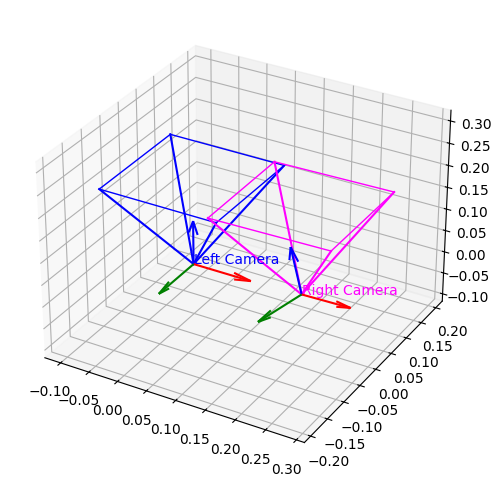

In [9]:
# Create plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot left camera (origin)
plot_camera(ax, R0, C0.flatten(), color='blue', label='Left Camera')
# Plot right camera
plot_camera(ax, R1, C1.flatten(), color='magenta', label='Right Camera')

set_axes_equal(ax)

Rectify some pairs

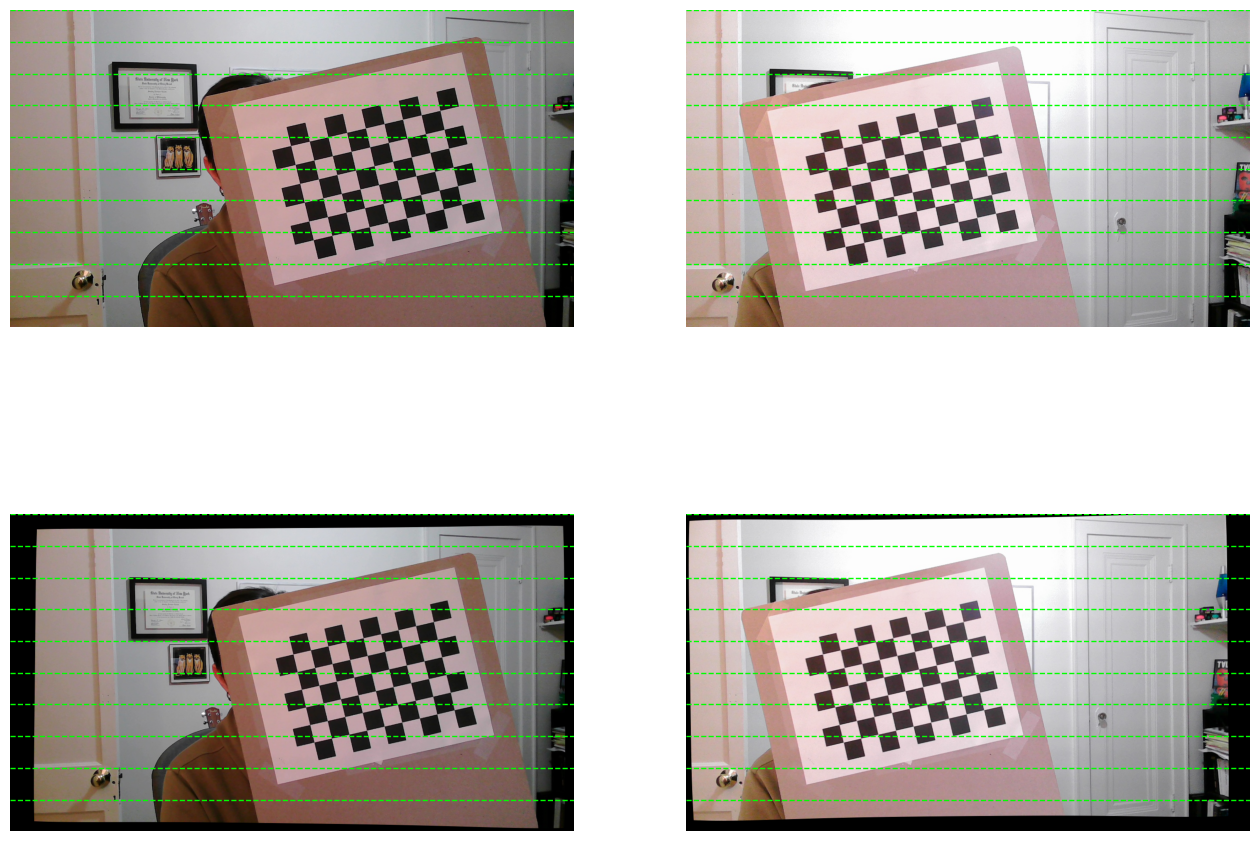

In [41]:
import cv2

idx = 1
img_l = cv2.imread(f"checkerboard/left_{idx}.jpg")
img_r = cv2.imread(f"checkerboard/right_{idx}.jpg")


image_size = img_l.shape[::-1][1:]

cameraMatrix1 = data['cameraMatrix1']
distCoeffs1 = data['distCoeffs1']
cameraMatrix2 = data['cameraMatrix2']
distCoeffs2 = data['distCoeffs2']

R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cameraMatrix1=cameraMatrix1,
    distCoeffs1=distCoeffs1,
    cameraMatrix2=cameraMatrix2,
    distCoeffs2=distCoeffs2,
    imageSize=image_size,
    R=R,
    T=T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=1
)

# Compute undistortion
left_map1, left_map2 = cv2.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1, image_size, cv2.CV_16SC2,
)
right_map1, right_map2 = cv2.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2, image_size, cv2.CV_16SC2,
)

# Apply rectification
rect_left = cv2.remap(img_l, left_map1, left_map2, cv2.INTER_LINEAR)
rect_right = cv2.remap(img_r, right_map1, right_map2, cv2.INTER_LINEAR)

def plot_with_horizontal_lines(img, line_count=10, color='lime'):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    height = img.shape[0]

    for i in range(line_count):
        y = int(i * height / line_count)
        plt.axhline(y=y, color=color, linewidth=1, linestyle='--')
    
    plt.axis('off')

plt.figure(figsize=(16, 12))

plt.subplot(2,2,1)
# plt.imshow(cv2.cvtColor(img_l, cv2.COLOR_BGR2RGB))
plot_with_horizontal_lines(img_l)
plt.subplot(2,2,2)
# plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))
plot_with_horizontal_lines(img_r)
plt.subplot(2,2,3)
plot_with_horizontal_lines(rect_left)
plt.subplot(2,2,4)
# plt.imshow(rect_right)
plot_with_horizontal_lines(rect_right)

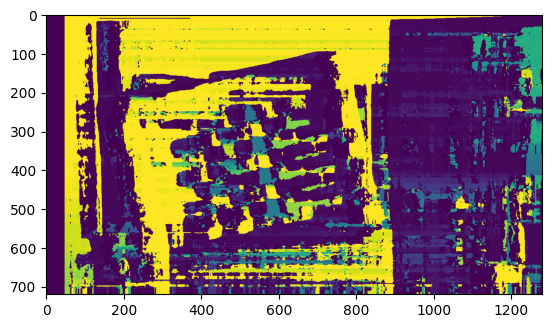

In [48]:
import cv2
import numpy as np

gray_l = cv2.cvtColor(rect_left, cv2.COLOR_BGR2GRAY)
gray_r = cv2.cvtColor(rect_right, cv2.COLOR_BGR2GRAY)

# Create StereoSGBM object with parameters
window_size = 10
min_disp = 0
num_disp = 16 * 3   # must be divisible by 16

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
)

disparity = stereo.compute(gray_l, gray_r).astype(np.float32) / 16.0

disp_vis = (disparity - min_disp) / num_disp

plt.imshow(disp_vis)
plt.show()

Try feature detection

In [63]:
orb = cv2.ORB_create(nfeatures=500)
keypoints_l, descriptors_l = orb.detectAndCompute(img_l, None)
keypoints_r, descriptors_r = orb.detectAndCompute(img_r, None)

# Match features
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_l, descriptors_r)
matches = sorted(matches, key=lambda x: x.distance)

good_matches = matches[:50]

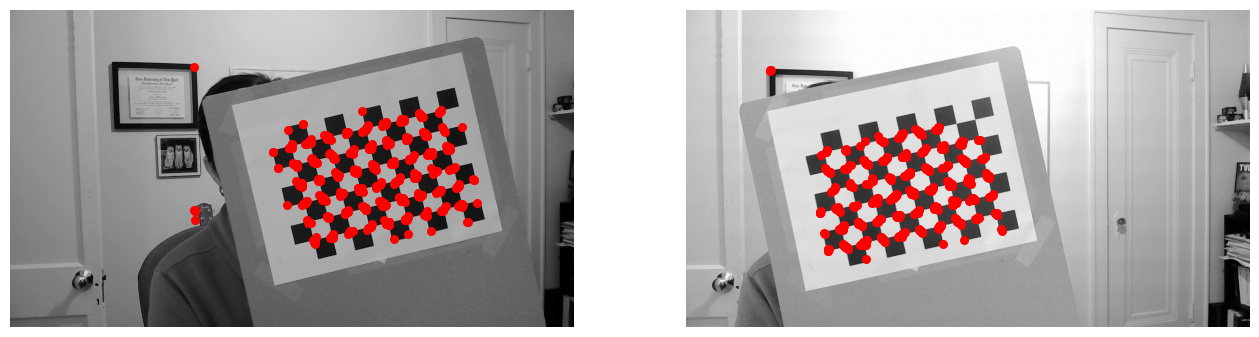

In [64]:
fig, ax = plt.subplots(figsize=(16,8), ncols=2)

ax[0].imshow(cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY), cmap='gray')
# Extract coords
points = [kp.pt for kp in keypoints_l]
# Separate the coords
x_c = [p[0] for p in points]
y_c = [p[1] for p in points]

ax[0].scatter(x_c, y_c, c='r', s=30, marker='o')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY), cmap='gray')
# Extract coords
points = [kp.pt for kp in keypoints_r]
# Separate the coords
x_c = [p[0] for p in points]
y_c = [p[1] for p in points]

ax[1].scatter(x_c, y_c, c='r', s=30, marker='o')
ax[1].axis('off')
plt.show()

